# Notebook to develop S/N QA (mainly figures)  [v2]
    v2 -- 18.7 and cframe!
    v3 -- Refactor SNRFit

In [52]:
# imports
from importlib import reload

import numpy as np
from scipy import optimize

from matplotlib import pyplot as plt

import yaml

from desispec.qa import qalib
from desispec.io import read_frame, read_params

## Run QA
    desi_qa_frame --frame_file=cframe-b1-00000021.fits

## Test file

In [2]:
tst_file = '/home/xavier/DESI/DESI_SCRATCH/18.7/spectro/redux/mini/QA/exposures/20200316/00000021/qa-b1-00000021.yaml'

In [3]:
# Read yaml
with open(tst_file, 'r') as infile:
    qa_data = yaml.load(infile)

/home/xavier/Projects/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


### Check it

In [4]:
qa_data['20200316'][21]['b1']['S2N']['PARAMS']

{'BIN_SZ': 0.1,
 'B_CONT': [[4000.0, 4500.0], [5250.0, 5550.0]],
 'PCHI_RESID': 0.05,
 'PER_RESID': 95.0,
 'R_CONT': [[5950.0, 6200.0], [6990.0, 7230.0]],
 'SKYCONT_ALARM_RANGE': [50.0, 600.0],
 'SKYCONT_WARN_RANGE': [100.0, 400.0],
 'SKYRESID_ALARM_RANGE': [-10.0, 10.0],
 'SKYRESID_WARN_RANGE': [-5.0, 5.0],
 'Z_CONT': [[8120.0, 8270.0], [9110.0, 9280.0]]}

In [5]:
qa_data['20200316'][21]['b1']['S2N']['METRICS'].keys()

dict_keys(['EXPTIME', 'FIDSNR_TGT', 'FILTERS', 'FITCOEFF_TGT', 'FITCOVAR_TGT', 'FIT_FILTER', 'MAGNITUDES', 'MEDIAN_SNR', 'NUM_NEGATIVE_SNR', 'OBJLIST', 'SCIENCE_FIBERID', 'SNR_MAG_TGT', 'SNR_RESID', 'STAR_FIBERID', 'r2'])

In [6]:
qa_data['20200316'][21]['b1']['S2N']['METRICS']['OBJLIST']

['SCIENCE', 'STD']

### Short cut

In [7]:
s2n_dict = qa_data['20200316'][21]['b1']['S2N']['METRICS']

### Re-shape mags

In [8]:
all_mags = np.resize(np.array(s2n_dict['MAGNITUDES']), (500,3))
all_mags.shape

(500, 3)

In [9]:
fidx = np.where(np.array(qa_data['20200316'][21]['b1']['S2N']['METRICS']['FILTERS']) == qa_data['20200316'][21]['b1']['S2N']['METRICS']['FIT_FILTER'])[0]
fidx                                                                                                                                       

array([0])

In [10]:
mags = all_mags[:,fidx].flatten()
mags.shape

(500,)

### Good sources (some are Infinite!)

In [11]:
gd_mag = np.isfinite(mags)
np.sum(~gd_mag)

40

## Plots

### Scatter me

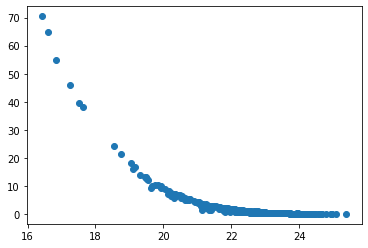

In [12]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], np.array(s2n_dict['MEDIAN_SNR'])[gd_mag])
#
plt.show()

### Residual

In [13]:
exptime = qa_data['20200316'][21]['b1']['S2N']['METRICS']['EXPTIME']
exptime

1068.323891763128

In [14]:
r2= qa_data['20200316'][21]['b1']['S2N']['METRICS']['r2']
funcMap={"linear":lambda x,a,b:a+b*x,
         "poly":lambda x,a,b,c:a+b*x+c*x**2,
         "astro":lambda x,a,b:(exptime*a*x)/np.sqrt(exptime*(a*x+b)+r2)
        }

In [15]:
fitfunc = funcMap['astro']

In [16]:
sci_idx = qa_data['20200316'][21]['b1']['S2N']['METRICS']['OBJLIST'].index('SCIENCE')
sci_idx

0

In [17]:
coeff = qa_data['20200316'][21]['b1']['S2N']['METRICS']['FITCOEFF_TGT'][sci_idx]
coeff

[0.02817235631243733, 0.9126296252761991]

In [18]:
x=10**(-0.4*(mags[gd_mag]-22.5))
fit_snr = fitfunc(x,  *coeff)
fit_snr[0:50]

array([ 1.36442528,  0.95790377,  0.49065736,  1.58962013,  1.23940546,
        1.46917792,  0.51455701,  1.36262026,  3.40150129,  1.68522799,
        0.21250464,  1.27527656,  9.59322434,  0.60613509,  0.79580406,
        2.84026592,  0.25478221, 11.27119514,  0.10254784,  1.09194889,
        6.2654671 ,  0.65933352,  0.14025526,  0.37517679,  0.5143374 ,
        6.96764836,  0.78559341,  0.65711137,  0.93635351,  1.63254071,
        0.77759261,  0.25835161,  0.39707204,  0.46172426,  0.81988059,
        3.09893787,  1.16607547,  0.50500013,  0.33444672,  0.35865504,
        0.48262426,  0.88986687,  0.62737275,  2.07023483,  1.08415799,
        0.15792563,  0.46796233,  0.30871621,  0.8111805 ,  0.33784691])

In [19]:
r2

0.0

In [20]:
resid = (np.array(s2n_dict['MEDIAN_SNR'])[gd_mag]-fit_snr)/fit_snr

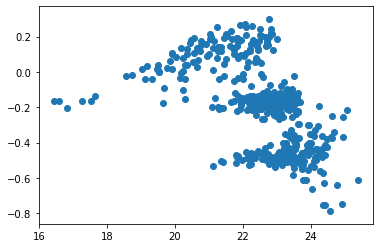

In [21]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], resid)
#
plt.show()

### With fit

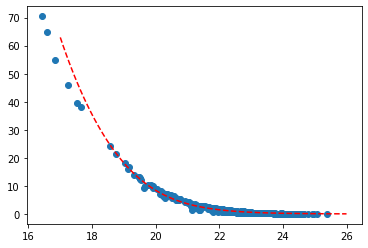

In [22]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], np.array(s2n_dict['MEDIAN_SNR'])[gd_mag])
# Fit
xmag = np.linspace(17., 26., 100)
xval=10**(-0.4*(xmag-22.5))
yval = fitfunc(xval, *coeff)
ax.plot(xmag, yval, '--r')
#
#ax.set_ylim(5., 20.)
#
plt.show()

#### Note the points at very bright values are likely stars

----

# Refactor

## Fitting

In [32]:
def fit_astro(flux, A, B):
    return flux*A/np.sqrt(A*flux + B)

### Normalize

In [25]:
snr_norm = np.array(s2n_dict['MEDIAN_SNR'])[gd_mag] / exptime**(1/2)

### Fit

In [29]:
flux = 10**(-0.4*(mags[gd_mag]-22.5))

In [43]:
popt, pcov = optimize.curve_fit(fit_astro, flux, snr_norm, p0=(0.02, 1.))

/home/xavier/Projects/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [44]:
popt

array([0.01817394, 0.31367139])

In [45]:
fit_snr = fit_astro(flux, *popt)

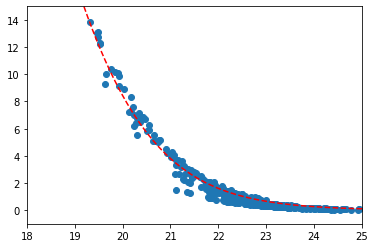

In [47]:
plt.clf()
ax=plt.gca()
#
ax.scatter(mags[gd_mag], np.array(s2n_dict['MEDIAN_SNR'])[gd_mag])
# Fit
xmag = np.linspace(17., 26., 100)
xval=10**(-0.4*(xmag-22.5))
yval = fit_astro(xval, *popt) * exptime**(1/2)
ax.plot(xmag, yval, '--r')
#
ax.set_xlim(18., 25.)
ax.set_ylim(-1., 15.)
#
plt.show()

In [38]:
coeff

[0.02817235631243733, 0.9126296252761991]

# Test frame

## Load

In [91]:
cframe_file = '/home/xavier/DESI/DESI_SCRATCH/19.9/spectro/redux/mini/exposures/20200319/00000031/cframe-r6-00000031.fits'

In [92]:
cframe = read_frame(cframe_file)

In [93]:
cframe.fibermap[0:5]

TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SECONDARY_TARGET,TARGET_RA,TARGET_DEC,TARGET_RA_IVAR,TARGET_DEC_IVAR,BRICKID,BRICK_OBJID,MORPHTYPE,PRIORITY,SUBPRIORITY,REF_ID,PMRA,PMDEC,REF_EPOCH,PMRA_IVAR,PMDEC_IVAR,RELEASE,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERFLUX_W1,FIBERFLUX_W2,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FIBERTOTFLUX_W1,FIBERTOTFLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,EBV,PHOTSYS,OBSCONDITIONS,NUMOBS_INIT,PRIORITY_INIT,NUMOBS_MORE,HPXPIXEL,FIBER,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,OBJTYPE,LAMBDA_REF,FIBERASSIGN_X,FIBERASSIGN_Y,FA_TARGET,FA_TYPE,NUMTARGET,FIBER_RA,FIBER_DEC,FIBER_RA_IVAR,FIBER_DEC_IVAR,PLATEMAKER_X,PLATEMAKER_Y,PLATEMAKER_RA,PLATEMAKER_DEC,NUM_ITER,SPECTROID,BRICKNAME,LAMBDAREF,DELTA_X,DELTA_Y
int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,str4,int32,float64,int64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,int32,int64,int64,int32,int64,int32,int32,int32,int32,int32,str3,float32,float32,float32,int64,uint8,int16,float64,float64,float32,float32,float32,float32,float32,float32,int32,int32,str8,float64,float64,float64
288230398381525773,2,0,0,0,153.22906494140625,32.36728286743164,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.4595715,0.57716286,1.1503456,3.6870852,3.4385738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3000,6,223,6223,0,TGT,5400.0,-272.08463,294.61902,0,0,0,153.22906494140625,32.36728286743164,0.0,0.0,0.0,0.0,0.0,0.0,2,6,1532p322,5400.0,0.0,0.0
288230398381528088,4,0,0,0,153.11613011208414,32.29122242015634,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.2529559,2.4505348,6.1622024,15.664776,9.684527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3001,6,490,6490,0,TGT,5400.0,-246.56375,273.41003,0,0,0,153.11613011208414,32.29122242015634,0.0,0.0,0.0,0.0,0.0,0.0,2,6,1530p322,5400.0,0.0,0.0
288230398381525858,2,0,0,0,153.2256317138672,32.32523727416992,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0155638,1.0150532,2.1647947,4.5215282,4.0674963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3002,6,277,6277,0,TGT,5400.0,-271.0014,283.4717,0,0,0,153.2256317138672,32.32523727416992,0.0,0.0,0.0,0.0,0.0,0.0,2,6,1532p322,5400.0,0.0,0.0
288230398389916125,4,0,0,0,152.50286865234375,32.2934455871582,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,5.9567423,5.52375,5.9335985,11.265748,16.126411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3003,6,337,6337,0,TGT,5400.0,-114.49704,269.69635,0,0,0,152.50286865234375,32.2934455871582,0.0,0.0,0.0,0.0,0.0,0.0,2,6,1524p322,5400.0,0.0,0.0
288230398381528089,4,0,0,0,153.15214212187317,32.30268743818072,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.6961661,0.93952763,2.5805094,6.9446425,5.0716367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,3004,6,276,6276,0,TGT,5400.0,-254.57202,276.7705,0,0,0,153.15214212187317,32.30268743818072,0.0,0.0,0.0,0.0,0.0,0.0,2,6,1532p322,5400.0,0.0,0.0


In [94]:
params = read_params()

## Run

In [95]:
reload(qalib)
qadict = qalib.SNRFit(cframe, 'r6', params['qa']['s2n'])

Starting SNR Fit
Working on ELG
Working on LRG
Working on QSO
Working on MWS
Working on STAR
End SNR Fit


----

In [22]:
np.array(s2n_dict['MAGNITUDES']).size

1500

In [21]:
np.array(s2n_dict['MEDIAN_SNR']).size

500